### Simulating my first TD(0)

> Value function for TD(0) is
$$
V_t(s) = V_t(s) + \alpha(r_t + V_{t+1}(s+1) - V_t(s))
$$

In [1]:
import numpy as np

## Computing the value function of TD(0) for the random walk problem from the book

In [2]:
def V(n):
    values = 0.5*np.ones(5)
    for _ in xrange(n):
        alpha = 0.1
        s = 2
        leftOrRight = np.random.choice((-1,1))
        new_s = s + leftOrRight
        while new_s >= 0 and new_s <= 4:
            values[s] = values[s] + alpha*(values[new_s] - values[s])
            s = new_s
            leftOrRight = np.random.choice((-1,1))
            new_s = s + leftOrRight
                        
        values[s] = values[s] + alpha*((new_s+1)/float(6) - values[s])
    return values
    
    

In [3]:
actual_V = [1/6., 2/6., 3/6., 4/6., 5/6.]

In [4]:
import matplotlib.pyplot as plt

In [5]:
from IPython.core.pylabtools import figsize

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
figsize(10,7)

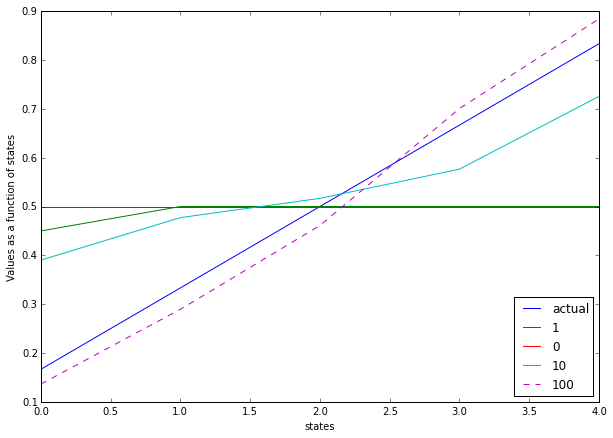

In [8]:
plt.plot(range(5),actual_V)
plt.plot(range(5), V(1))
plt.plot(range(5), V(0))
plt.plot(range(5), V(10))
plt.plot(range(5), V(100), '--')
plt.legend(['actual', '1', '0', '10', '100'], loc='lower right')
plt.xlabel('states')
plt.ylabel('Values as a function of states')

## Monte Carlo simulation of random walk problems

In [9]:
def rmserror(array1, array2):
    return np.sqrt(((array1 - array2)**2).mean())


In [10]:
def mcV(n, alpha):
    values = 0.5*np.ones(5)
    for _ in xrange(n):
        s = 2
        state_reward = np.zeros(5)
        state_occur = np.zeros(5)
        episode = [s]
        leftOrRight = np.random.choice((-1,1))
        new_s = s + leftOrRight
        state_occur[s] += 1
        while new_s >= 0 and new_s <= 4:
            episode.append(new_s)
            state_occur[new_s] += 1
            s = new_s
            leftOrRight = np.random.choice((-1,1))
            new_s = s + leftOrRight
        reward = (new_s+1)/6.
        for state in episode:
            state_reward[state] += reward
        
        values[np.where(state_occur !=0)] += alpha*(state_reward[np.where(state_occur !=0)]
                                                    /state_occur[np.where(state_occur !=0)]
                                                    -values[np.where(state_occur !=0)])
    return values

In [11]:
def tdV(n, alpha):
    values = 0.5*np.ones(5)
    for _ in xrange(n):
        s = 2
        leftOrRight = np.random.choice((-1,1))
        new_s = s + leftOrRight
        while new_s >= 0 and new_s <= 4:
            values[s] = values[s] + alpha*(values[new_s] - values[s])
            s = new_s
            leftOrRight = np.random.choice((-1,1))
            new_s = s + leftOrRight
                        
        values[s] = values[s] + alpha*((new_s+1)/float(6) - values[s])
    return values

In [12]:
def averaging(n, func, alpha):
    avg = 0
    for _ in xrange(T):
        avg += rmserror(actual_V, func(n, alpha))
    return avg/T

In [13]:
def avgRmsError(n, func, alpha):
    return [averaging(k, func, alpha) for k in range(1,n+1)]


In [14]:
alpha = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15]

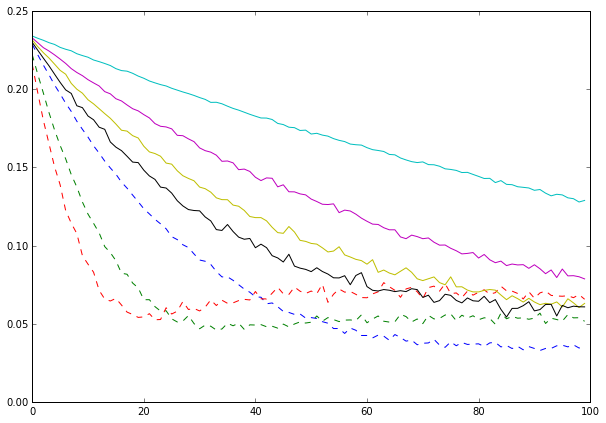

In [15]:
T = 100
for a in alpha[-3:]:
    plt.plot(range(100), avgRmsError(100, tdV, a), '--')
for a in alpha[:-3]:
    plt.plot(range(100), avgRmsError(100, mcV, a), '-')

## The plot seems correct as it is in the book. But I am still trying to understand why the rms error goes down and then goes up. 

Intution:
> Since $\alpha$ is high, the algorithm has high weight on correction term. Converge fast, but then the corrections term kicks in.

## Batch updating of TD(0)

### Generating 100 samples

In [16]:
def generatingSamples(n):
    samples = []
    for _ in xrange(n):
        s = 2
        episode = [s]
        leftOrRight = np.random.choice((-1,1))
        new_s = s + leftOrRight
        while new_s >= 0 and new_s <= 4:
            episode.append(new_s)
            s = new_s
            leftOrRight = np.random.choice((-1,1))
            new_s = s + leftOrRight
        episode.append(new_s)
        samples.append(episode)
    return samples

In [44]:
def updateRuleMC(V, episode, ind, alpha):
    return alpha*((episode[-1]+1)/6- V[episode[ind]])

In [45]:
def updateRuleTD(V, episode, ind, alpha):
    if ind < len(episode) -2:
        return alpha*(V[episode[ind+1]] - V[episode[ind]])
    else:
        return alpha*((episode[-1]+1)/6- V[episode[ind]])

In [126]:
def batch(updateRule, alpha):
    error = np.zeros(T)
    for _ in range(N):        
        samples = generatingSamples(100)
        V = 0.5*np.ones(5)
        for i in range(T):
            for episode in samples:
                reward = [updateRule(V, episode, ind, alpha) for ind in range(len(episode)-1)]
                for r, state in zip(reward, episode[:-1]):
                    V[state] += r
            error[i] += rmserror(actual_V, V)
    return error/N

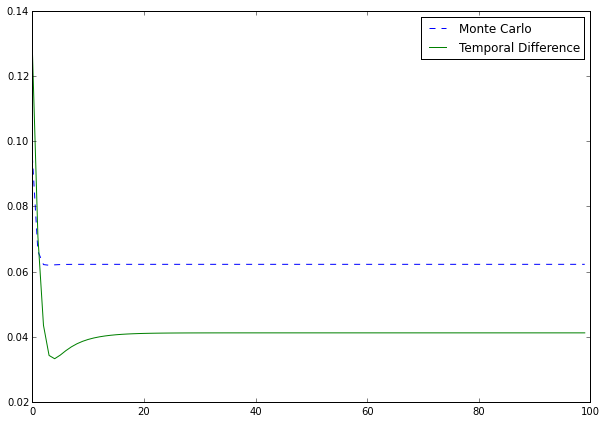

In [129]:
T=100
N = 20
plt.plot(batch(updateRuleMC, 0.01), '--',label='Monte Carlo' )
plt.plot(batch(updateRuleTD, 0.01), '-', label='Temporal Difference')
plt.legend()